In [1]:
from model import unet
from input.augment import *

Using TensorFlow backend.


In [2]:
from keras.optimizers import RMSprop, Adam
from model.losses import bce_dice_loss, dice_loss, weighted_bce_dice_loss, weighted_dice_loss, dice_coeff

In [3]:
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
import os
%matplotlib inline

In [4]:
BATCH_SIZE = 8

PATH = '/home/paperspace/data/lyft_challenge'
INPUT_FOLDER = 'CameraRGB'
LABELS_FOLDER = 'CameraSeg'

WEIGHTS_LOC = 'lyft/weighted-512.hdf5'

In [ ]:
global_files_list = pd.read_csv(PATH + '/files.txt')

In [6]:
print(len(global_files_list))

In [7]:
all_image_ids = list(range(len(global_files_list)))
train_ids, test_ids = train_test_split(all_image_ids, test_size=0.01, random_state=42)

train_ids, valid_ids = train_test_split(train_ids, test_size=0.1, random_state=21)

print('Training on {} samples'.format(len(train_ids)))
print('Validating on {} samples'.format(len(valid_ids)))
print('Testing on {} samples'.format(len(test_ids)))

Training on 11154 samples
Validating on 1240 samples
Testing on 126 samples


In [8]:
def get_img_mask(idx, target_size=(256,512), resize=True):
    top_crop = 120 # cut out sky
    bottom_crop = 520 # cut out hood of car
    img = cv2.imread(global_files_list['rgb'][idx])
    labels = cv2.imread(global_files_list['label'][idx])
    red = labels[:,:,2]
    label_cars = (red == 10).astype('uint8')
    label_roads = ((red == 6) | (red == 7)).astype('uint8')
    label_cars[496:,:] = 0
    
    if resize:
        img = img[top_crop:bottom_crop,:,:]
        img = np.clip(img, 0, 255)
        img = cv2.resize(img, (target_size[1], target_size[0]), cv2.INTER_CUBIC)
        
        label_cars = label_cars[top_crop:bottom_crop,:]
        label_cars = np.where(label_cars > 0.1, 1, 0)
        label_roads = label_roads[top_crop:bottom_crop,:]
        label_roads = np.where(label_roads > 0.8, 1, 0)
    mask = np.dstack((label_cars, label_roads))
    
    if resize:
        mask = cv2.resize(mask.astype('uint8'), (target_size[1], target_size[0]), cv2.INTER_CUBIC)
        
    return img, mask

2542


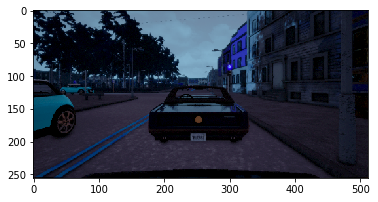

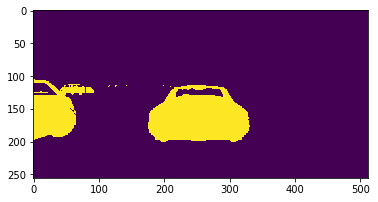

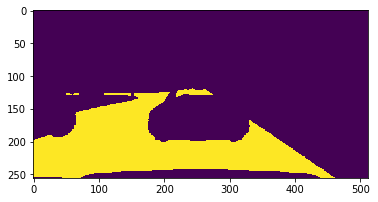

In [9]:
idx = random.randint(0, len(global_files_list))
img, mask = get_img_mask(9834, resize=True)

print(idx)

plt.imshow(img)
plt.show()

plt.imshow(mask[:,:,0])
plt.show()

plt.imshow(mask[:,:,1])
plt.show()

In [10]:
def Carla_Generator(image_ids, batch_size=8, augment=False):
    while True:
        for start in range(0, len(image_ids), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(image_ids))
            batch_ids = image_ids[start:end]
            for idx in batch_ids:
                img, mask = get_img_mask(idx)
                if augment:
                    img = randomHueSaturationValue(img,
                                                   hue_shift_limit=(-50, 50),
                                                   sat_shift_limit=(-5, 5),
                                                   val_shift_limit=(-30, 30))
                    img, mask = randomShiftScaleRotate(img, mask,
                                                       shift_limit=(-0.08, 0.08),
                                                       scale_limit=(-0.1, 0.1),
                                                       rotate_limit=(-0.1, 0.1))
                    img, mask = randomHorizontalFlip(img, mask)

                x_batch.append(img)
                y_batch.append(mask)
            x_batch = np.array(x_batch, np.float32) / 255
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch

In [11]:
model = unet.unet_512(input_shape=(256, 512, 3), num_classes=2)
model.compile(optimizer=Adam(lr=0.0001), loss=weighted_bce_dice_loss, metrics=[dice_coeff])

In [12]:
if os.path.exists(WEIGHTS_LOC):
    print('Loaded weights')
    model.load_weights(WEIGHTS_LOC)

Loaded weights


In [13]:
TRAIN = True

In [15]:
if TRAIN:
    model.fit_generator(generator=Carla_Generator(train_ids, augment=True),
                    steps_per_epoch=np.ceil(float(len(train_ids)) / float(BATCH_SIZE)),
                    epochs=100,
                    callbacks=[
                        EarlyStopping(monitor='val_loss',
                           patience=4,
                           verbose=1,
                           min_delta=1e-4),
                        ReduceLROnPlateau(monitor='val_loss',
                            factor=0.1,
                            patience=2,
                            verbose=1,
                            epsilon=1e-4),
                         ModelCheckpoint(monitor='val_loss',
                            filepath=WEIGHTS_LOC,
                            save_best_only=True,
                            save_weights_only=True),
                        TensorBoard(log_dir='./unet-512-logs/')],
                    validation_data=Carla_Generator(valid_ids, augment=False),
                    validation_steps=np.ceil(float(len(valid_ids)) / float(BATCH_SIZE)))

Epoch 1/100
1395/1395 [==============================] - 517s 371ms/step - loss: 0.5496 - dice_coeff: 0.5908 - val_loss: 0.3183 - val_dice_coeff: 0.7240
Epoch 2/100
1395/1395 [==============================] - 511s 366ms/step - loss: 0.2379 - dice_coeff: 0.7975 - val_loss: 0.1519 - val_dice_coeff: 0.8759
Epoch 3/100
1395/1395 [==============================] - 511s 366ms/step - loss: 0.1308 - dice_coeff: 0.9070 - val_loss: 0.1022 - val_dice_coeff: 0.9413
Epoch 4/100
1395/1395 [==============================] - 511s 366ms/step - loss: 0.0911 - dice_coeff: 0.9509 - val_loss: 0.0680 - val_dice_coeff: 0.9674
Epoch 5/100
1395/1395 [==============================] - 511s 366ms/step - loss: 0.0726 - dice_coeff: 0.9686 - val_loss: 0.0575 - val_dice_coeff: 0.9775
Epoch 6/100
1395/1395 [==============================] - 511s 366ms/step - loss: 0.0634 - dice_coeff: 0.9767 - val_loss: 0.0559 - val_dice_coeff: 0.9801
Epoch 7/100
1395/1395 [==============================] - 510s 366ms/step - loss: 0

KeyboardInterrupt: 

In [16]:
model.save_weights(WEIGHTS_LOC)

# Inference

In [17]:
model = unet.unet_512(input_shape=(256, 512, 3), num_classes=2)

In [18]:
model.load_weights(WEIGHTS_LOC)

In [19]:
def predict_masks(x_batch, model):
    start_time = time.time()
    preds = model.predict_on_batch(x_batch)
    print('Prediction on {} samples: {}s'.format(len(x_batch), time.time()-start_time))
    masks = []
    for pred in preds:
        mask = np.zeros_like(pred)
        mask[:,:,0] = (pred[:,:,0] > 0.1).astype('uint8')
        mask[:,:,1] = (pred[:,:,1] > 0.8).astype('uint8')
        masks.append(mask)
    return masks

In [20]:
original = []
labels = []

for idx in test_ids:
    img, true = get_img_mask(idx, resize=False)
    original.append(img)
    labels.append(true)

In [21]:
y_pred = []

generator = Carla_Generator(test_ids, 10)

for i in range(len(test_ids) // BATCH_SIZE):
    x_batch, y_batch = next(generator)
    masks = predict_masks(x_batch, model)

    for idx, mask in enumerate(masks):
        mask = cv2.resize(mask, (800,400))
        mask = np.pad(mask, ((120,80), (0,0), (0,0)), mode='constant', constant_values=0)
        mask[:,:,0] = np.where(mask[:,:,0]>0,1,0)
        mask = mask.astype('uint8')
        y_pred.append(mask)
    

Prediction on 10 samples: 1.7258896827697754s
Prediction on 10 samples: 0.13002824783325195s
Prediction on 10 samples: 0.13423824310302734s
Prediction on 10 samples: 0.1311631202697754s
Prediction on 10 samples: 0.13404536247253418s
Prediction on 10 samples: 0.1301102638244629s
Prediction on 10 samples: 0.13243961334228516s
Prediction on 10 samples: 0.12971901893615723s
Prediction on 10 samples: 0.13306832313537598s
Prediction on 10 samples: 0.13153886795043945s
Prediction on 10 samples: 0.1313633918762207s
Prediction on 10 samples: 0.12976360321044922s
Prediction on 6 samples: 0.6127364635467529s
Prediction on 10 samples: 0.1306471824645996s
Prediction on 10 samples: 0.13168740272521973s


[3429, 11582, 9121, 4058, 11351]


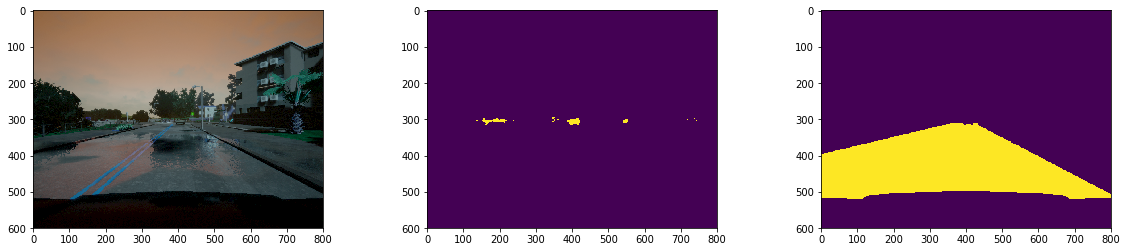

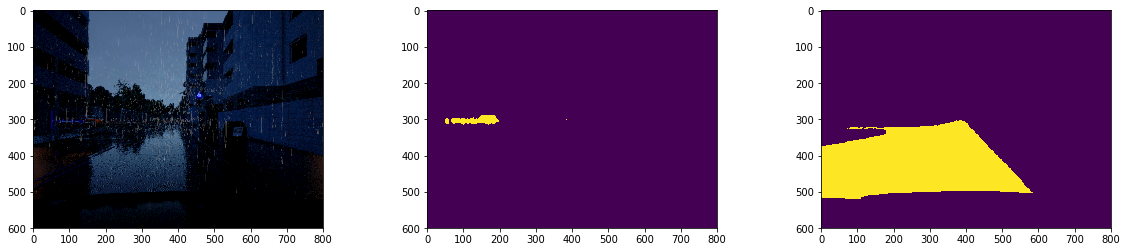

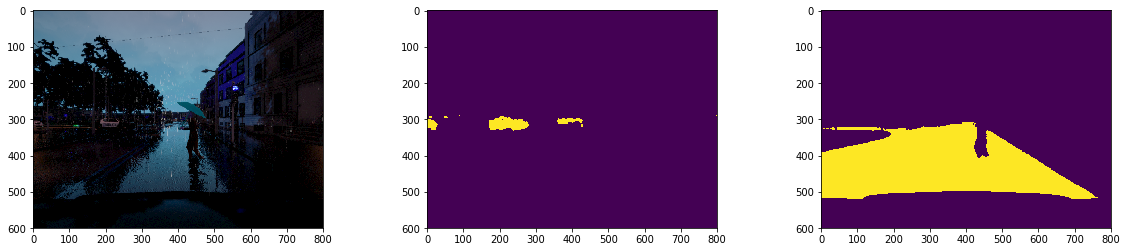

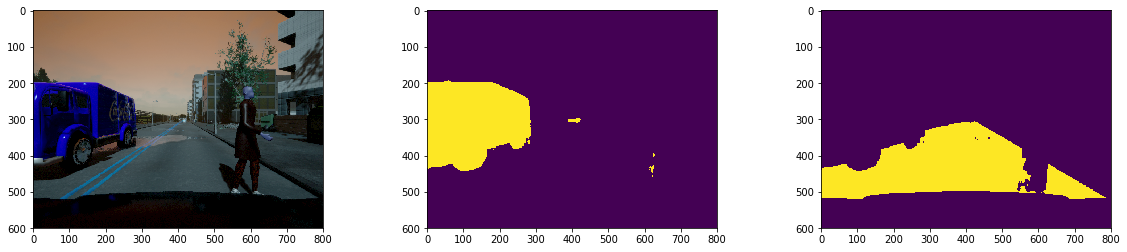

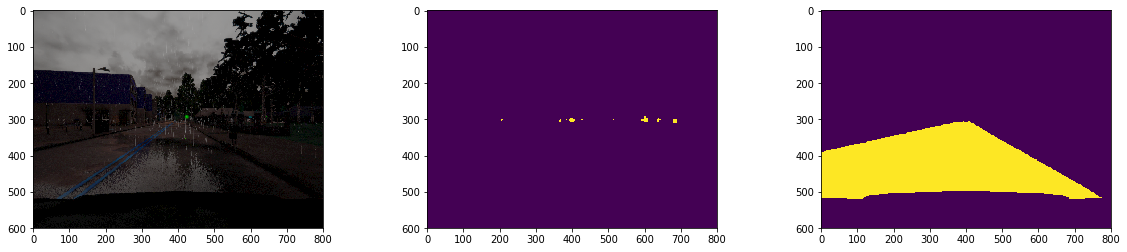

In [22]:
random_sample = random.sample(test_ids, 5)

print(random_sample)

for sample in random_sample:
    idx = test_ids.index(sample)
    plt.figure(figsize=(20,4))
    
    plt.subplot(131)
    img = original[idx]
    plt.imshow(img)
    
    mask = y_pred[idx]
    plt.subplot(132)
    mask_1 = mask[:,:,0]
    plt.imshow(mask_1)
    plt.subplot(133)
    mask_2 = mask[:,:,1]
    plt.imshow(mask_2)

    plt.show()

[3429, 11582, 9121, 4058, 11351]


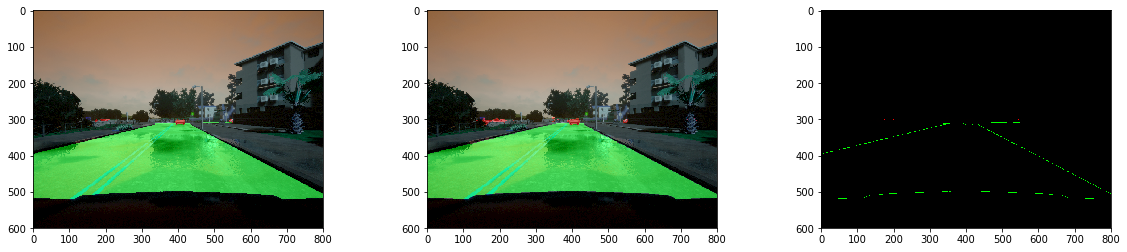

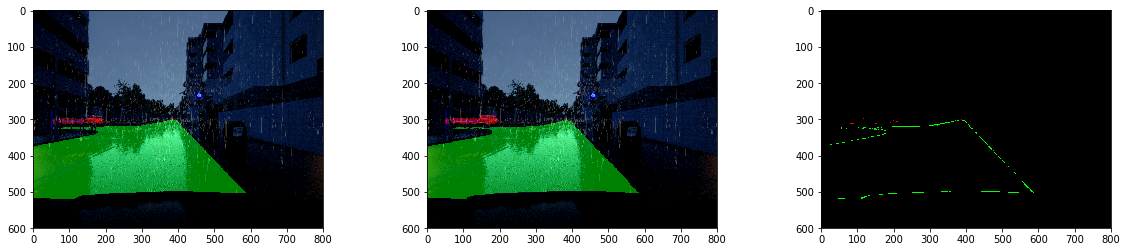

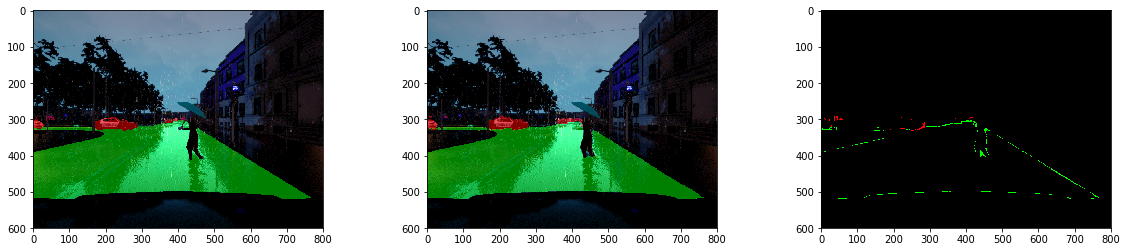

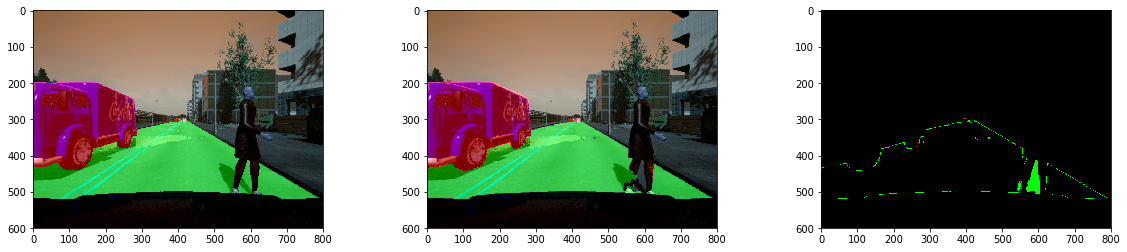

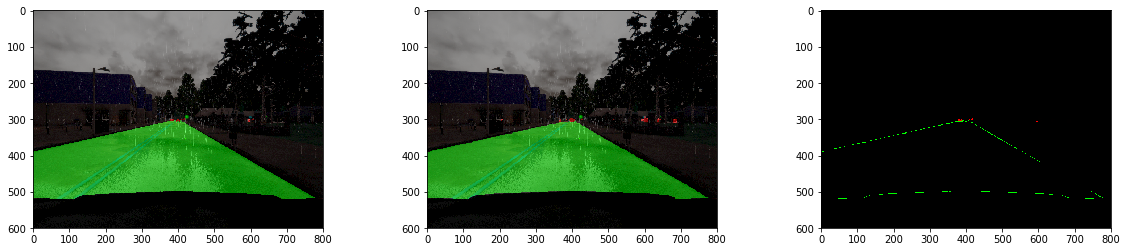

In [23]:
print(random_sample)
for sample in random_sample:
    idx = test_ids.index(sample)
    plt.figure(figsize=(20,4))

    img = original[idx]
    
    overlay = np.zeros_like(img)
    truth = labels[idx]
    overlay[:,:,0] = truth[:,:,0] * 255
    overlay[:,:,1] = truth[:,:,1] * 255
    
    combined = cv2.addWeighted(img, 1, overlay, 0.5, 0)
    
    plt.subplot(131)
    plt.imshow(combined)
    
    overlay = np.zeros_like(img)
    mask = y_pred[idx]
    overlay[:,:,0] = mask[:,:,0] * 255
    overlay[:,:,1] = mask[:,:,1] * 255
    
    combined = cv2.addWeighted(img, 1, overlay, 0.5, 0)
    plt.subplot(132)
    plt.imshow(combined)
    
    
    overlay = np.zeros_like(img)
    diff = truth - mask

    overlay[:,:,0] = diff[:,:,0] * 255
    overlay[:,:,1] = diff[:,:,1] * 255
    
    plt.subplot(133)
    plt.imshow(overlay)
    
    plt.show()

In [24]:
def calculate_f1_scores(labels, preds, n_classes, betas=[2,0.5]):
    # List of  TP, FP, TN, FN for each class
    results = np.zeros((n_classes, 4))
    scores = np.zeros((n_classes, 3))
    for c in range(n_classes):
        for n in range(len(labels)):
            results[c,0] += np.sum(np.logical_and(preds[n][:,:,c] == 1, labels[n][:,:,c] == 1)) # TP
            results[c,1] += np.sum(np.logical_and(preds[n][:,:,c] == 1, labels[n][:,:,c] == 0)) # FP
            results[c,2] += np.sum(np.logical_and(preds[n][:,:,c] == 0, labels[n][:,:,c] == 0)) # TN
            results[c,3] += np.sum(np.logical_and(preds[n][:,:,c] == 0, labels[n][:,:,c] == 1)) # FN
        scores[c,0] = results[c,0] / (results[c,0] + results[c,1]) /1.0 # Precision
        scores[c,1] = results[c,0] / (results[c,0] + results[c,3]) /1.0 # Recall
        scores[c,2] = (1+betas[c]**2) * ((scores[c,0]*scores[c,1])/(betas[c]**2 * scores[c,0] + scores[c,1]))
    return scores

In [25]:
scores = calculate_f1_scores(labels, y_pred, n_classes=2)

In [26]:
car_scores = scores[0]
road_scores = scores[1]

print('Car F-Score: {}, Precision: {}, Recall: {}'.format(car_scores[2],car_scores[0],car_scores[1]))
print('Road F-Score: {}, Precision: {}, Recall: {}'.format(road_scores[2],road_scores[0],road_scores[1]))


Car F-Score: 0.9586899702675569, Precision: 0.8562120177132897, Recall: 0.9882606026140918
Road F-Score: 0.9955710958847426, Precision: 0.9992398830797123, Recall: 0.9811614525773936
